In [399]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.datasets import *
import matplotlib.pyplot as plt
from typing import List, Tuple, Union
from itertools import product
from copy import deepcopy
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [331]:
class Node:
    def __init__(self, n: int, w: np.array = None):
        """The 0th weight is w0"""
        
        self.n = n
        if w is not None:
            assert len(w) == n + 1, 'Number of weights must be equal to number of inputs + 1'
            self.w = w
        else: 
            self.w = np.random.uniform(0, 1, n + 1)
    
    def activation(self, a: float) -> float:
        return NotImplementedError
    
    def d_activation(self, x: np.array):
        return NotImplementedError
    
    def __call__(self, x: Union[np.array, None] = None) -> float:
        return self.activation(self.w[1:] @ x) + self.w[0]
    
    def error(self, x: np.array, y: float):
        return (y - self(x)) ** 2
    
    def d_error_d_y(self, x: np.array, y:float):
        return 2 * (self(x) - y)
    
    def __repr__(self):
        return f"Node(n={self.n}, w={self.w})"

    
class NodeLinear(Node):
    def __init__(self, n: int, w: np.array = None):
        super().__init__(n, w)
        self.type = 'linear'

    def activation(self, a: float) -> float:
        return a
    
    def d_activation(self, x: np.array):
        return 1 
    
        
class NodeLogistic(Node):
    def __init__(self, n: int, w: np.array = None):
        super().__init__(n, w)
        self.type = 'logistic'

    def activation(self, a: float) -> float:
        return 1 / (1 + np.exp(-a))
    
    def d_activation(self, x: np.array):
        a = self.w[1:] @ x + self.w[0]
        return np.exp(-a) / (1 + np.exp(-a)) ** 2

In [332]:
class MultiLayerPerceptron:
        
    def __init__(self, x_size: int, structure: Tuple[int], node_type: type[Node] = NodeLogistic):
        """structure: the i'th int is the number of nodes in layer i"""
        
        assert structure[-1] == 1, 'final layer must have exactly one node'
        
        self.layers = []
        last_n = x_size
        for i, n in enumerate(structure):
            self.layers.append([node_type(last_n) for _ in range(n)])
            last_n = n
            
        self.learning_rate = 0.05
    
    def __call__(self, x: np.array):
        outputs = x
        for layer in self.layers:
            outputs = np.array([node(outputs) for node in layer])
        return outputs[0]
    
    def forward(self, x: np.array):
        all_outputs = []
        outputs = x
        for layer in self.layers:
            outputs = np.array([node(outputs) for node in layer])
            all_outputs.append(outputs)
        return all_outputs
    
    def backward(self, x: np.array, y: float):
        results = []
        all_outputs = self.forward(x)
        all_inputs = [x] + all_outputs[:-1]
        all_deltas = []
        
        for i in range(len(self.layers)):
            inputs = all_inputs[::-1][i]
            outputs = all_outputs[::-1][i]
            layer = self.layers[::-1][i]
        
            d_activations = [node.d_activation(inputs) for node in layer]
            if i == 0:
                deltas = np.array([2 * (outputs[0] - y) * d_activations[0]])
            
            else:
                next_layer = self.layers[::-1][i-1]
                next_weights = np.array([node.w for node in next_layer])
                deltas = (deltas @ next_weights[:, 1:]) * d_activations
                
            all_deltas = [deltas] + all_deltas
                        
        for i in range(len(self.layers)):
            for j in range(len(self.layers[i])):
                self.layers[i][j].w[1:] -= all_deltas[i][j] * all_inputs[i] * self.learning_rate
                self.layers[i][j].w[0] -= all_deltas[i][j] * self.learning_rate

                    
    def error(self, x: np.array, y: float):
        return (y - self(x)) ** 2
    
    
    def plot(self, x: np.array = None):
        f, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')

        lines_to_plot = []
        
        if x is not None:
            all_outputs = self.forward(x)

        for i, layer in enumerate(self.layers):
            start_count = layer[0].n
            end_count = len(layer)
            for start in range(start_count):
                for end in range(end_count):
                    ax.plot(
                        [i, i+1],
                        [start - 0.5 * (start_count-1), end - 0.5 * (end_count-1)],
                        color='k',
                        linewidth=np.clip(abs(layer[end].w[start+1] * 5), 0.01, 10),
                        zorder=0
                    )

            for end in range(end_count):
                ax.add_patch(
                    plt.Circle(
                        [i+1, end - 0.5 * (end_count-1)], 
                        0.2,
                        facecolor='gray',
                        zorder=1
                    )
                )
                
                if x is not None:
                    z = round(all_outputs[i][end], 5)
                    w0 = round(self.layers[i][end].w[0], 5)
                    ax.text(
                        i+1, 
                        end - 0.5 * (end_count-1), 
                        f'w0 = {w0}\nz = {z}', 
                        horizontalalignment='center'
                    )

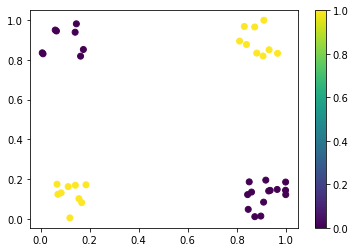

In [478]:
observations = 40
xs = (np.random.uniform(0, 0.2, observations*2) + np.random.choice([0, 0.8], observations*2)).reshape([observations, 2])
ys = (np.sign(xs - 0.5).prod(axis=1) + 1) / 2
plt.scatter(xs[:, 0], xs[:, 1], c=ys)
plt.colorbar();

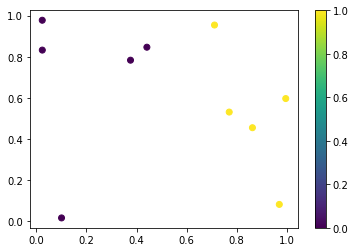

In [468]:
observations = 10
xs = np.random.uniform(0, 1, observations*2).reshape([observations, 2])
ys = np.where(xs[:, 0] < 0.5, 0, 1)
plt.scatter(xs[:, 0], xs[:, 1], c=ys)
plt.colorbar();

(0.0, 57.181878477480154)

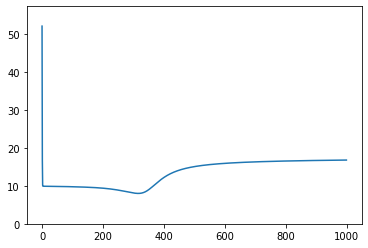

In [480]:
mlp = MultiLayerPerceptron(2, [5, 1], node_type=NodeLogistic)

errors = []
intermediate_mlps = []

for _ in range(1000):
    intermediate_mlps.append(deepcopy(mlp))
    for i in range(len(xs)):
        mlp.backward(xs[i], ys[i])
    errors.append(sum([mlp.error(xs[i], ys[i]) for i in range(len(xs))]))

plt.plot(errors)
plt.ylim(0, max(errors) * 1.1)

In [481]:
f = go.Figure()

for layer in range(len(mlp.layers)):
    for j in range(len(mlp.layers[layer])):
        for i in range(len(mlp.layers[layer][j].w)):
            weights = [m.layers[layer][j].w[i] for m in intermediate_mlps]
            f.add_trace(go.Scatter(y=weights, name=f'layer {layer + 1}, node {j + 1}, w{i}'))

f

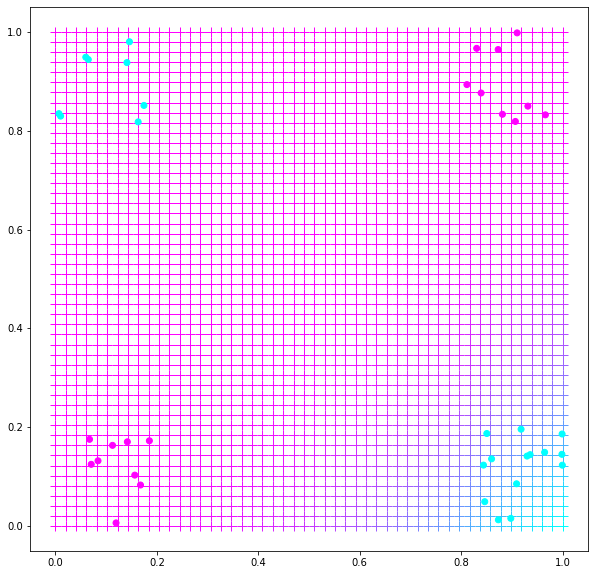

In [482]:
fig, ax = plt.subplots(figsize=(10, 10))

xs_test = np.array(list(product(np.linspace(0, 1, 50), np.linspace(0, 1, 50))))
ys_test = [mlp(x) for x in xs_test]

ax.scatter(xs_test[:, 0], xs_test[:, 1], c=ys_test, cmap='cool', marker='+', s=110, linewidths=1)

ax.scatter(x=xs[:, 0], y=xs[:, 1], c=ys, cmap='cool')


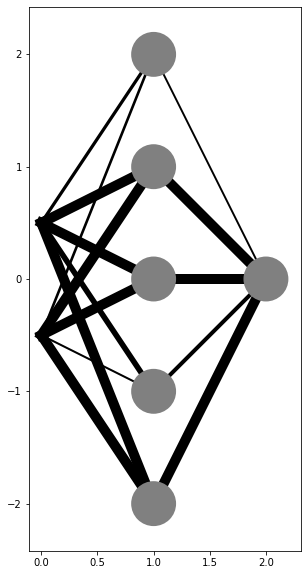

In [484]:
mlp.plot()